# Electricity Load Forecasting with a Seasonal Naïve Baseline
This notebook builds and evaluates a simple multi-horizon baseline model to forecast electricity load up to 24 hours ahead.
The baseline uses a seasonal naïve strategy: each forecasted value equals the observed load from the same hour one week earlier (lag = 168 hours).
It includes data preparation, testing on unseen data, and performance 

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

## Data Loading

In [ ]:
# Define the Paths for loading the data
interim_folder = "../data/processed"

# Load the CSV with the data for all years
train_val_df = pd.read_csv(os.path.join(interim_folder, "train_val_df.csv"), sep=';', decimal=',')
test_df = pd.read_csv(os.path.join(interim_folder, "test_df.csv"), sep=';', decimal=',')

# Take a quick look at the training data
train_val_df.head(1)

# Take a quick look at the test data
test_df.head(1)


,timestamp,load_MWh,lag_1,lag_2,lag_3,lag_6,lag_24,lag_168,lag_336,lag_672,lag_8760,hour,weekday,is_weekend
0,2024-01-01 00:00:00,40170.25,42140.0,44088.5,45158.75,52607.25,38361.75,40748.0,47626.0,49797.5,40646.5,0,0,0


## Data Preparation

In [4]:
# Convert timestamp to datetime
train_val_df["timestamp"] = pd.to_datetime(train_val_df["timestamp"])
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

# Define the features and targets
feature_cols = [c for c in train_val_df.columns if c not in ["timestamp", "load_MWh"]]
target_col = "load_MWh"

X_trainval = train_val_df[feature_cols]
y_trainval = train_val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"Train/Val samples: {X_trainval.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"Feature count: {len(feature_cols)}")
train_val_df["load_MWh"].describe()

Train/Val samples: 17517, Test samples: 8783
Feature count: 12


count    17517.000000
mean     53694.217503
std       9460.250499
min      30902.750000
25%      45940.500000
50%      53714.000000
75%      60986.250000
max      78680.500000
Name: load_MWh, dtype: float64

## Evaluation of the Baseline Model

The seasonal naïve baseline assumes strong weekly seasonality and predicts each future load value using the observed load from the same weekday and hour one week earlier (lag = 168 hours).

For each forecast origin t, a complete 24-hour forecast path (t+1 to t+24) is generated.  
Predictions are created in non-overlapping daily windows (step = 24).  

Forecast errors are computed for each horizon and aggregated to obtain overall RMSE and MAPE as well as horizon-specific performance metrics.




In [ ]:
# Testing on Future Data (Baseline Evaluation)
def seasonal_naive_24h_forecast(train_val_df, test_df, target_col="load_MWh",
                               horizon=24, step=24, seasonal_lag=168, eps=1e-6):
    """
    Multi-horizon seasonal naïve baseline using lag = 168h (same hour last week).

    Definition:
      - Forecast origin is time t (row index = start in test set)
      - Baseline predicts y(t+h) as y(t+h-168)
      - Truth block is y[t+1] .. y[t+24] (same evaluation as RF notebook)

    Returns:
      - all_preds, all_truth (flattened, length = n_windows * horizon)
      - rmse_per_horizon (length = horizon)
      - mape_per_horizon (length = horizon)
      - errors_by_horizon (dict: h -> list of errors)
      - timestamps (matching timestamps for truth/preds)
    """

    # Combine train + test so we can access past values when forecasting in test
    full_df = pd.concat([train_val_df[["timestamp", target_col]],
                         test_df[["timestamp", target_col]]], axis=0).copy()
    full_df = full_df.sort_values("timestamp").reset_index(drop=True)

    # For fast lookup: map timestamp -> load value
    full_df["timestamp"] = pd.to_datetime(full_df["timestamp"])
    full_df = full_df.set_index("timestamp")

    # Prepare outputs
    all_preds = []
    all_truth = []
    timestamps = []
    errors_by_horizon = {h: [] for h in range(1, horizon + 1)}

    sse_per_h = np.zeros(horizon)
    ape_per_h = np.zeros(horizon)
    n_windows = 0

    # We iterate over test rows as forecast origins (same logic as RF)
    y_test_values = np.asarray(test_df[target_col])
    test_timestamps = pd.to_datetime(test_df["timestamp"]).reset_index(drop=True)

    for start in range(0, len(test_df) - (horizon + 1) + 1, step):
        origin_time = test_timestamps.iloc[start]

        # Truth block: t+1 .. t+24 (same as RF notebook)
        y_block = y_test_values[start + 1 : start + 1 + horizon]

        preds_24h = np.zeros(horizon)

        for h in range(1, horizon + 1):
            pred_time = test_timestamps.iloc[start + h]  # timestamp at t+h
            seasonal_time = pred_time - pd.Timedelta(hours=seasonal_lag)

            # baseline prediction = observed load at seasonal_time
            yhat = full_df.loc[seasonal_time, target_col] if seasonal_time in full_df.index else np.nan
            preds_24h[h - 1] = yhat

            err = y_block[h - 1] - yhat
            errors_by_horizon[h].append(err)

        # Handle possible NaNs (shouldn't happen if lag_168 exists throughout)
        if np.isnan(preds_24h).any() or np.isnan(y_block).any():
            continue

        errs = y_block - preds_24h
        sse_per_h += errs ** 2
        ape_per_h += np.abs(errs) / np.clip(np.abs(y_block), eps, None) * 100

        all_preds.extend(preds_24h.tolist())
        all_truth.extend(y_block.tolist())

        # store timestamps for this 24h block
        timestamps.extend(test_timestamps.iloc[start + 1 : start + 1 + horizon].tolist())

        n_windows += 1

    rmse_per_horizon = np.sqrt(sse_per_h / n_windows)
    mape_per_horizon = ape_per_h / n_windows

    total_rmse = np.sqrt(mean_squared_error(all_truth, all_preds))
    total_mape = np.mean(
        np.abs((np.array(all_truth) - np.array(all_preds)) /
               np.clip(np.abs(np.array(all_truth)), eps, None))
    ) * 100

    print(f"Overall RMSE: {total_rmse:.2f}")
    print(f"Overall MAPE: {total_mape:.2f}%")

    return (
        np.array(all_preds),
        np.array(all_truth),
        rmse_per_horizon,
        mape_per_horizon,
        errors_by_horizon,
        timestamps
    )

horizon = 24
step = 24

preds, truth, mean_rmse_h, mean_mape_h, errors_by_horizon, timestamps = seasonal_naive_24h_forecast(
    train_val_df=train_val_df,
    test_df=test_df,
    target_col=target_col,
    horizon=horizon,
    step=step,
    seasonal_lag=168
)

results_df = pd.DataFrame({
    "timestamp": timestamps,
    "Actual_Load_MWh": truth,
    "Predicted_Load_MWh": preds
})

results_df.head()

Overall RMSE: 4085.39
Overall MAPE: 5.09%


,timestamp,Actual_Load_MWh,Predicted_Load_MWh
0,2024-01-01 01:00:00,38818.25,38502.00
1,2024-01-01 02:00:00,37847.75,36941.00
2,2024-01-01 03:00:00,37123.25,37002.00
3,2024-01-01 04:00:00,36753.75,37503.00
4,2024-01-01 05:00:00,37051.25,37378.25


## Visualization of the Model Performance

### 1. Daily Average Electricity Load: Actual vs Predicted

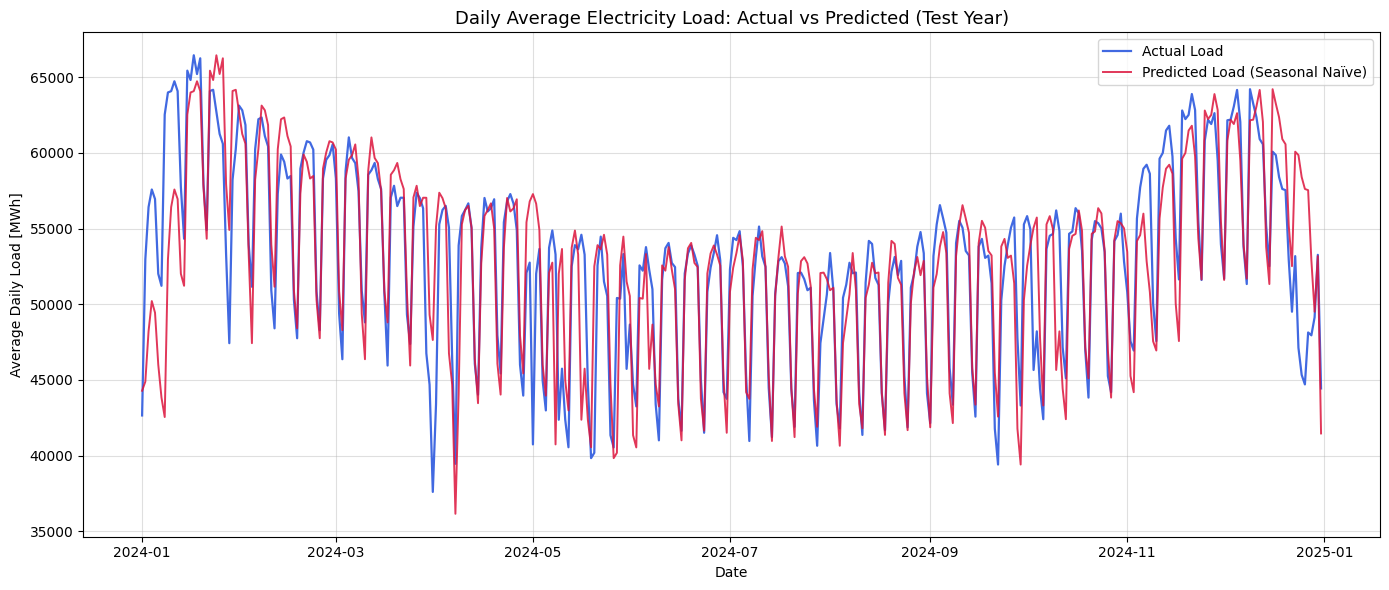

In [6]:
# Hourly predictions are aggregated to daily averages to visualize overall forecast behavior.
results_df["timestamp"] = pd.to_datetime(results_df["timestamp"])
daily_df = results_df.resample("D", on="timestamp").mean()

plt.figure(figsize=(14,6))
plt.plot(daily_df.index, daily_df["Actual_Load_MWh"], label="Actual Load", color="royalblue", linewidth=1.6)
plt.plot(daily_df.index, daily_df["Predicted_Load_MWh"], label="Predicted Load (Seasonal Naïve)", color="crimson", linewidth=1.4, alpha=0.85)
plt.title("Daily Average Electricity Load: Actual vs Predicted (Test Year)", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Average Daily Load [MWh]")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

### 2. Average RMSE & MAPE per Forecast Step

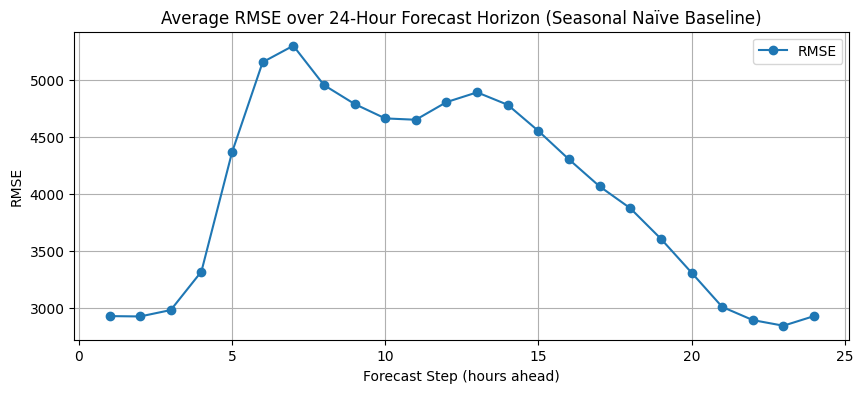

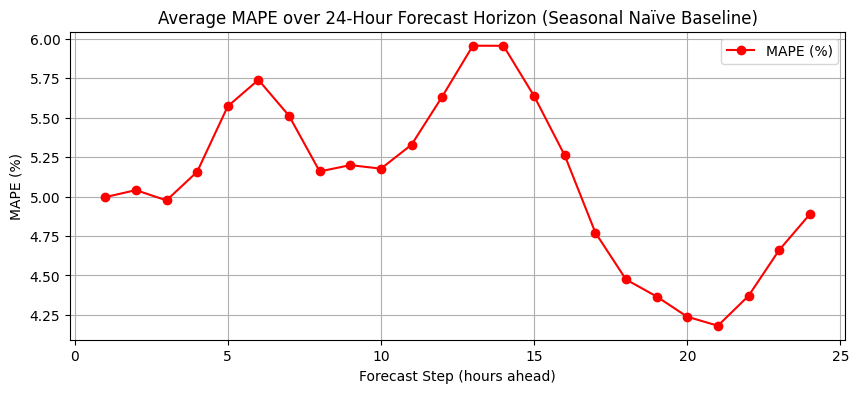

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(range(1, 25), mean_rmse_h, marker='o', label='RMSE')
plt.title("Average RMSE over 24-Hour Forecast Horizon (Seasonal Naïve Baseline)")
plt.xlabel("Forecast Step (hours ahead)")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(range(1, 25), mean_mape_h, color='red', marker='o', label='MAPE (%)')
plt.title("Average MAPE over 24-Hour Forecast Horizon (Seasonal Naïve Baseline)")
plt.xlabel("Forecast Step (hours ahead)")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.legend()
plt.show()


### 3. Error Distribution Comparison

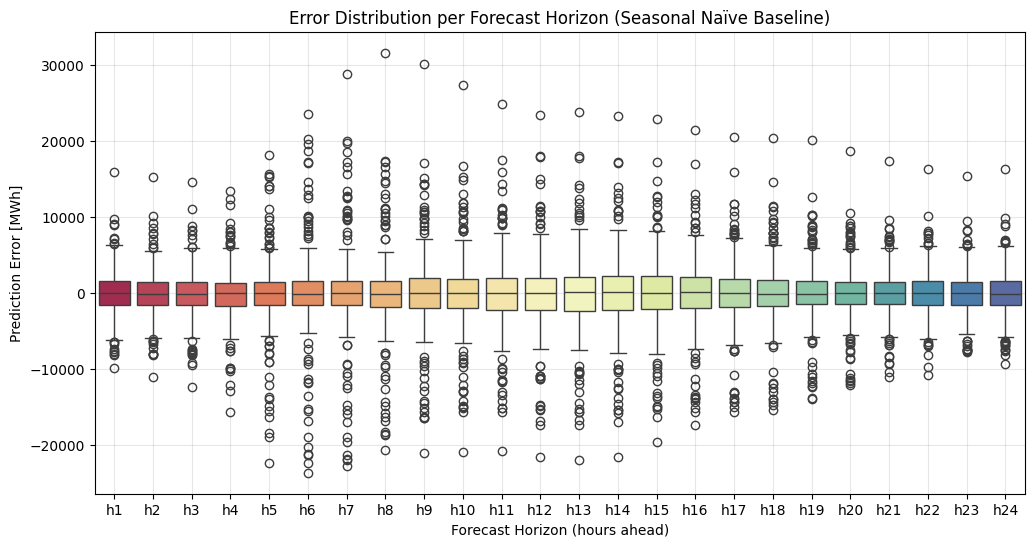

In [ ]:
errors_df = pd.DataFrame({f"h{h}": errors_by_horizon[h] for h in range(1, 25)})

plt.figure(figsize=(12,6))
sns.boxplot(data=errors_df, palette="Spectral")
plt.title("Error Distribution per Forecast Horizon (Seasonal Naïve Baseline)")
plt.xlabel("Forecast Horizon (hours ahead)")
plt.ylabel("Prediction Error [MWh]")
plt.grid(True, alpha=0.3)
plt.show()


**Key Findings – Seasonal Naïve Baseline**

- The seasonal naïve baseline achieves surprisingly strong predictive performance, highlighting the dominant role of **weekly seasonality** in German electricity demand.
- The predicted daily average load closely follows the actual load trajectory across the test year, indicating that recurring weekly consumption patterns explain a substantial share of variability.
- Forecast errors vary systematically across the 24 forecast steps. Under the evaluation setting with `step=24`, these variations largely reflect **hour-of-day dependent forecast difficulty**, rather than a strictly monotonic increase with forecast horizon.
- Higher error levels are observed during periods typically associated with **steep load ramps and intra-day transitions**, such as morning and midday phases.
- Toward later forecast steps, error levels decrease again, suggesting that the baseline effectively captures **stable recurring daily patterns**.
- The error distribution analysis reveals increased variance and occasional extreme deviations during volatile periods, while most horizons remain centered around zero, indicating limited systematic bias.
- Overall, the seasonal naïve approach provides a **strong, transparent, and training-free benchmark**. Any advanced machine learning model should demonstrate consistent improvements beyond this baseline to justify its additional complexity.